## Introduction

## Setup

In [16]:
### Load the required packages

import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

seed = 100

In [17]:
### Load the dataset 
df = pd.read_csv('D:/Dataset/Side_project_Duplicate_question_detector/questions.csv', encoding='utf-8')

#### Overview of the dataset

In [18]:
print('Shape:')
print(df.shape)

print('\nSome examples:')
print(df.head())

print('\nInformation:')
print(df.info())

print('\nAny NAs?')
print(np.sum(df.isnull()))

Shape:
(404351, 6)

Some examples:
   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  

Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 colu

There are only two NAs in this dataset, we can consider removing them since they account for very little part in this dataset.

In [19]:
### Target variable 

print('Distribution:')
print(df['is_duplicate'].value_counts())

print('\nDistribution in percentage:')
print(df['is_duplicate'].value_counts().apply(lambda x: x/len(df)*100))

Distribution:
0    255045
1    149306
Name: is_duplicate, dtype: int64

Distribution in percentage:
0    63.07515
1    36.92485
Name: is_duplicate, dtype: float64


Since the distribution of the target variable's classes are not so unbalanced, we can just move on

#### Remove the useless columns

In [20]:
### The columns qid1 and qid2 can be removed
df.drop(['qid1', 'qid2'], axis=1, inplace=True)

print(df.head()) # check the removal

   id                                          question1  \
0   0  What is the step by step guide to invest in sh...   
1   1  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2  How can I increase the speed of my internet co...   
3   3  Why am I mentally very lonely? How can I solve...   
4   4  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  


#### Remove the rows with NAs

In [21]:
df.dropna(how='any', inplace=True)

print(np.sum(df.isnull()))
print(df.info())

id              0
question1       0
question2       0
is_duplicate    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404349 entries, 0 to 404350
Data columns (total 4 columns):
id              404349 non-null int64
question1       404349 non-null object
question2       404349 non-null object
is_duplicate    404349 non-null int64
dtypes: int64(2), object(2)
memory usage: 15.4+ MB
None


#### Since we aim to find ways to detect the duplicate articles, we have to first split out part of the dataset for testing later

In [26]:
from sklearn.model_selection import train_test_split

df_tr, df_test = train_test_split(df, test_size=0.2, stratify=df['is_duplicate'], random_state=seed)

# check the split outcome 
print(df_tr['is_duplicate'].value_counts()/len(df_tr))
print(df_test['is_duplicate'].value_counts()/len(df_test))
print(df_tr.shape)
print(df_test.shape)

df_tr.index = range(len(df_tr))
df_test.index = range(len(df_test))

0    0.630749
1    0.369251
Name: is_duplicate, dtype: float64
0    0.630753
1    0.369247
Name: is_duplicate, dtype: float64
(323479, 4)
(80870, 4)


## EDA

#### The differences of length of each duplicate article

In [29]:
### Counstruct the tokenized object for each article 

print(df_tr['question1'][0])
print(df_tr['question2'][0])

from nltk.tokenize import word_tokenize

df_tr['q1_token'] = df_tr['question1'].apply(lambda x: word_tokenize(x))
df_tr['q2_token'] = df_tr['question2'].apply(lambda x: word_tokenize(x))

print(df_tr['q1_token'][0])
print(df_tr['q2_token'][0])

How do I get a passport if I live at two address?
Passport: I have changed my present address 4 months ago and am in need of a passport?


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


['How', 'do', 'I', 'get', 'a', 'passport', 'if', 'I', 'live', 'at', 'two', 'address', '?']
['Passport', ':', 'I', 'have', 'changed', 'my', 'present', 'address', '4', 'months', 'ago', 'and', 'am', 'in', 'need', 'of', 'a', 'passport', '?']


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [42]:
### create the column for calculating differences of length

df_tr['len_diff'] = df_tr.ix[:, ['q1_token', 'q2_token']].apply(lambda x: np.abs(len(x[0]) - len(x[1])), axis=1)

print(df_tr['len_diff'].head()) # checking

0    6
1    5
2    2
3    1
4    1
Name: len_diff, dtype: int64


C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


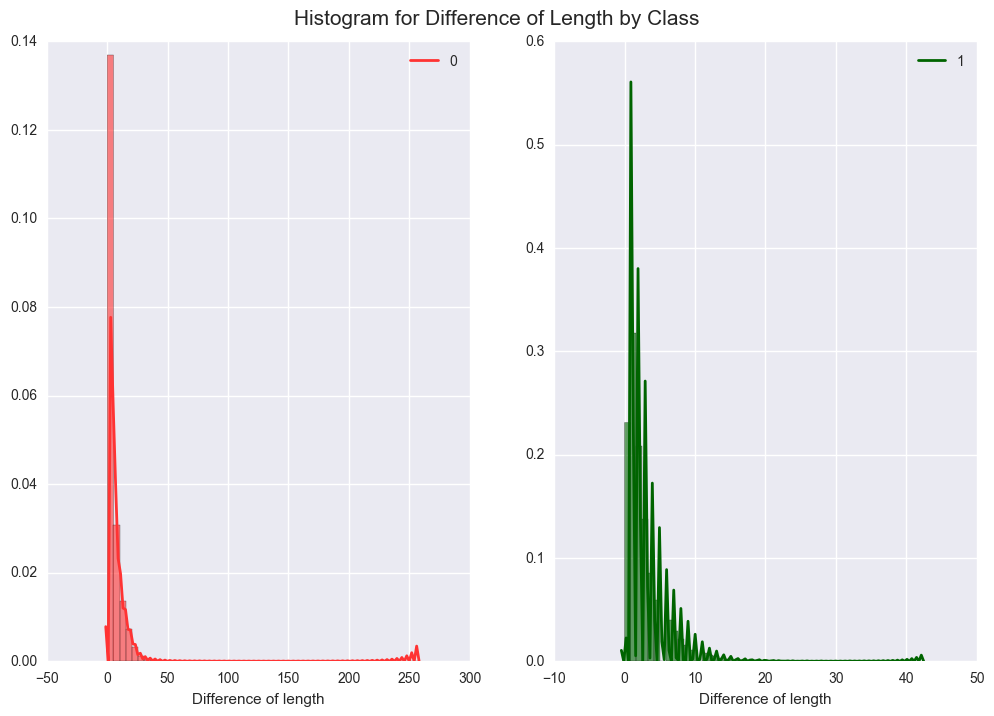

In [90]:
### Visualize the differences of length for each class

color_list = ['#FF3333', '#006400']


fig = plt.figure(figsize=[12, 8])
plt.suptitle('Histogram for Difference of Length by Class', fontsize=15, y=0.94)
for ind, col in enumerate(np.unique(df['is_duplicate']), start=1):
    axes = fig.add_subplot(1, 2, ind)
    sns.distplot(df_tr['len_diff'][df_tr['is_duplicate'].values == col].values,
                kde_kws={'alpha':1, 'label': str(col), 'lw':2}, 
                color = color_list[ind-1],
                hist_kws={'alpha':0.6})
    axes.set_xlabel('Difference of length')
    axes.legend()

From the two graphs above, I find that the differences in length of duplicate articles are less, which are larger than 50; however those in the non-duplicate group are more disperse and can be very large. That finding makes snese.